In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt


In [2]:
names = {
    "^GSPC": "S&P 500",
    "^FCHI": "CAC 40",
    "^DJI": "Dow Jones",
    "^IXIC": "Nasdaq"
}

tickers = ["NVDA","MSFT","AAPL","GOOGL","AMZN","META","AVGO","TSLA","BRK-B","JPM" ]

base_ticker = ['^GSPC']

label_base = names.get(base_ticker[0])
print(label_base)

S&P 500


In [10]:
def performance_metrics(returns, periods_per_year=252):
    returns = returns.dropna()

    cumulative_return = (1 + returns).prod() - 1
    annual_return = (1 + cumulative_return) ** (periods_per_year / len(returns)) - 1
    annual_volatility = returns.std() * np.sqrt(periods_per_year)

    sharpe_ratio = annual_return / annual_volatility if annual_volatility != 0 else np.nan

    equity_curve = (1 + returns).cumprod()
    rolling_max = equity_curve.cummax()
    drawdown = equity_curve / rolling_max - 1
    max_drawdown = drawdown.min()

    return {
        "Cumulative Return": cumulative_return,
        "Annualized Return": annual_return,
        "Annualized Volatility": annual_volatility,
        "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown": max_drawdown,
    }



--- Résultats sur une période de 3 month ---
Strategy performance : -0.66 %
Performance S&P 500   : 3.94 %
Surperformance        : -4.6 %


,Strategy,S&P 500
Cumulative Return,-0.006648,0.039404
Annualized Return,-0.032420,0.176237
Annualized Volatility,0.079226,0.113054
Sharpe Ratio,-0.409209,1.558880
Max Drawdown,-0.030869,-0.051101


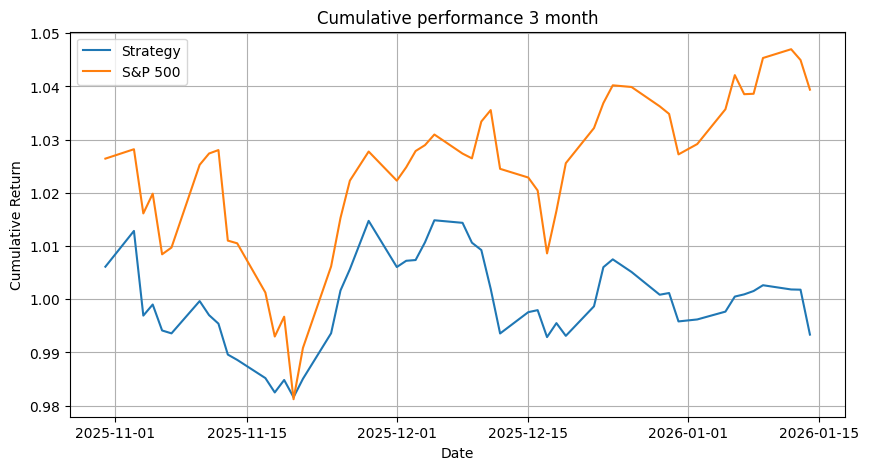


--- Résultats sur une période de 6 month ---
Strategy performance : 6.12 %
Performance S&P 500   : 9.85 %
Surperformance        : -3.73 %


,Strategy,S&P 500
Cumulative Return,0.061152,0.098484
Annualized Return,0.140202,0.212208
Annualized Volatility,0.101009,0.109394
Sharpe Ratio,1.388021,1.939849
Max Drawdown,-0.040167,-0.051101


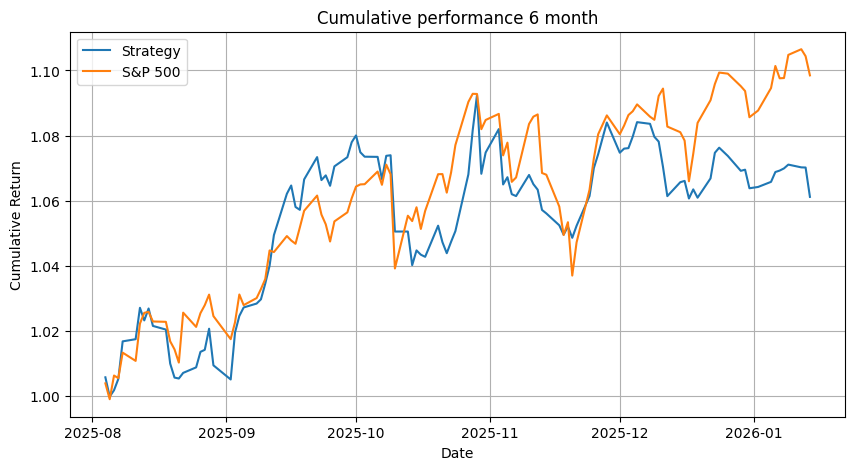


--- Résultats sur une période de 1 year ---
Strategy performance : 14.28 %
Performance S&P 500   : 16.42 %
Surperformance        : -2.14 %


,Strategy,S&P 500
Cumulative Return,0.142763,0.164152
Annualized Return,0.149745,0.165568
Annualized Volatility,0.131548,0.185558
Sharpe Ratio,1.138328,0.892272
Max Drawdown,-0.122330,-0.189022


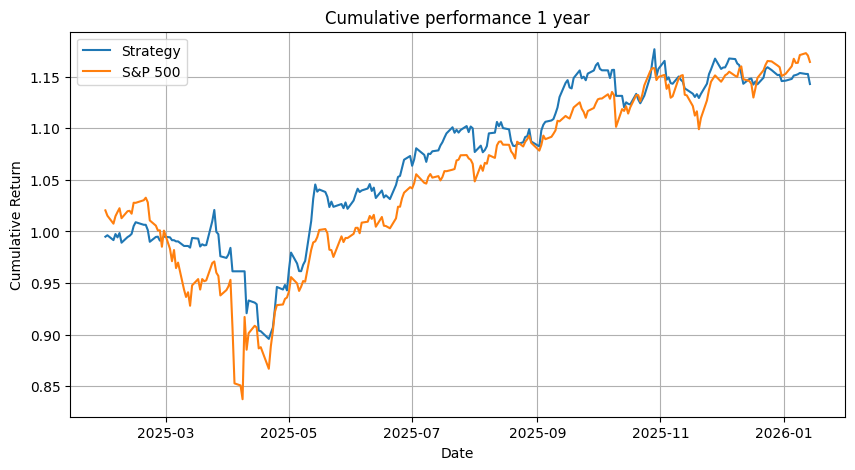


--- Résultats sur une période de 2 years ---
Strategy performance : 50.51 %
Performance S&P 500   : 45.33 %
Surperformance        : 5.18 %


,Strategy,S&P 500
Cumulative Return,0.505074,0.453342
Annualized Return,0.232946,0.206897
Annualized Volatility,0.134370,0.159507
Sharpe Ratio,1.733623,1.297101
Max Drawdown,-0.144040,-0.189022


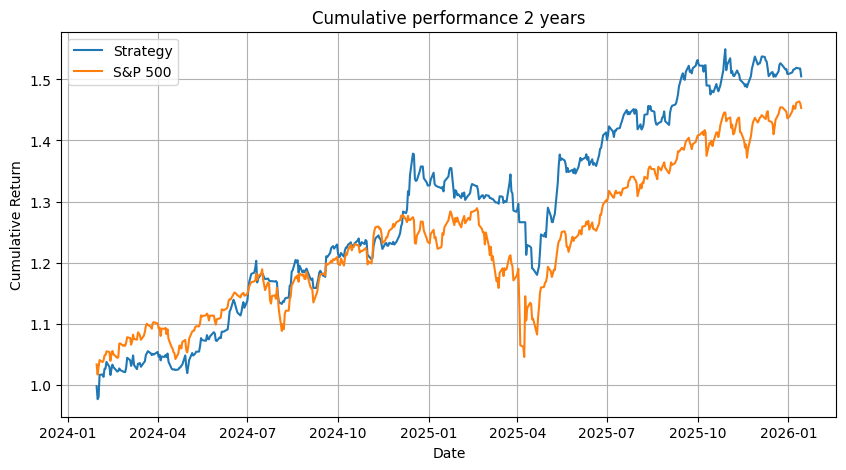


--- Résultats sur une période de 3 years ---
Strategy performance : 131.6 %
Performance S&P 500   : 73.56 %
Surperformance        : 58.04 %


,Strategy,S&P 500
Cumulative Return,1.315994,0.735568
Annualized Return,0.330066,0.203221
Annualized Volatility,0.138519,0.149893
Sharpe Ratio,2.382815,1.355771
Max Drawdown,-0.144040,-0.189022


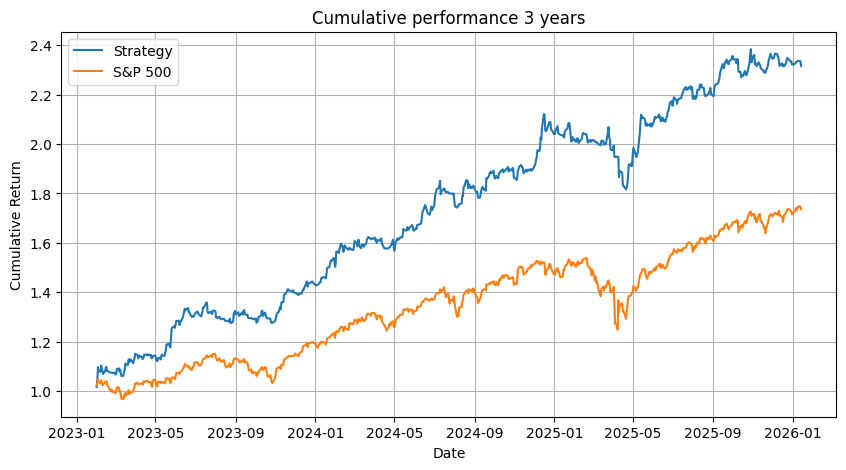


--- Résultats sur une période de 5 years ---
Strategy performance : 142.52 %
Performance S&P 500   : 82.33 %
Surperformance        : 60.19 %


,Strategy,S&P 500
Cumulative Return,1.425214,0.823313
Annualized Return,0.196574,0.128402
Annualized Volatility,0.147222,0.169450
Sharpe Ratio,1.335224,0.757754
Max Drawdown,-0.234835,-0.254251


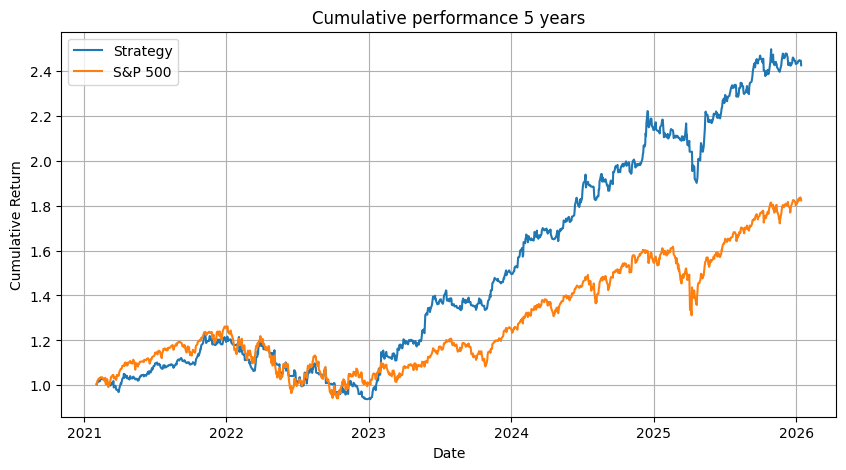

In [12]:
# Tests on different periods
period_options = {
    "3 month": 90,
    "6 month": 180,
    "1 year": 365,
    "2 years": 730,
    "3 years": 1095,
    "5 years":1825
}

window_size = 10

import matplotlib.pyplot as plt

for label, days in period_options.items():
    print(f"\n--- Résultats sur une période de {label} ---")
    
    end_date = datetime.today()
    start_date = end_date - timedelta(days=days)

    # Télécharger les données
    S = pd.DataFrame()
    for t in tickers:
        S[t] = yf.Ticker(t).history(start=start_date, end=end_date)['Close']

    for ticker in tickers:
        S[ticker] = S[ticker].ffill().bfill()
    
    D = pd.DataFrame()
    for t in base_ticker:
        D[t] = yf.Ticker(t).history(start=start_date, end=end_date)['Close']
    for ticker in base_ticker:
        D[ticker] = D[ticker].ffill().bfill()

    # Strategy implementation
    periods = []
    for i in range(len(S) - window_size):
        window = S.iloc[i:i + window_size]
        periods.append(window)

    signals = []
    for period in periods:
        avg = period.mean()
        last_price = period.iloc[-1]
        signal = (last_price > avg).astype(int).tolist()
        signals.append(signal)

    daily_returns = S.pct_change().dropna()
    returns_aligned = daily_returns.iloc[window_size-1:]
    signals_df = pd.DataFrame(signals, index=returns_aligned.index, columns=returns_aligned.columns)
    strategy_returns = returns_aligned * signals_df
    daily_portfolio_returns = strategy_returns.mean(axis=1)
    cumulative_strategy = (1 + daily_portfolio_returns).cumprod()
    returns_strat = round((cumulative_strategy.iloc[-1] - 1) * 100, 2)

    benchmark_returns = D.pct_change().dropna()
    cumulative_benchmark = (1 + benchmark_returns).cumprod()
    cumulative_benchmark = cumulative_benchmark.loc[cumulative_strategy.index]
    benchmark_total_return = round((cumulative_benchmark.iloc[-1, 0] - 1) * 100, 2)
    
    # === Metrics calculation ===
    metrics_strat = performance_metrics(daily_portfolio_returns)
    metrics_benchmark = performance_metrics(benchmark_returns.iloc[:, 0])



    print(f"Strategy performance : {returns_strat} %")
    print(f"Performance {label_base}   : {benchmark_total_return} %")
    print(f"Surperformance        : {round(returns_strat - benchmark_total_return, 2)} %")
    
    metrics_df = pd.DataFrame({"Strategy": metrics_strat,label_base: metrics_benchmark})
    display(
    metrics_df.style.format({
        "Cumulative Return": "{:.2%}",
        "Annualized Return": "{:.2%}",
        "Annualized Volatility": "{:.2%}",
        "Sharpe Ratio": "{:.2f}",
        "Max Drawdown": "{:.2%}"}))



    # Affichage graphique
    plt.figure(figsize=(10, 5))
    plt.plot(cumulative_strategy, label="Strategy")
    plt.plot(cumulative_benchmark, label=label_base)
    plt.title(f"Cumulative performance {label}")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.grid(True)
    plt.show()
